This notebook imports a 3D model of UBC campus, and uses antenna positions from an online database to generate radio power coverage simulations for campus

In [ ]:
%matplotlib notebook
%matplotlib inline

#Imports all related libraries
import sionna.rt
import matplotlib.pyplot as plt
import numpy as np
import math
import drjit as dr
import mitsuba as mi
from typing import Tuple, List
import random 
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies


import radio_functions

In [ ]:
#Load the UBC scene, and set parameters, such as frequency and type of transmitting + recieving antennas
current_scene = load_scene("UBC_3D_model/UBC.xml")
current_scene.frequency = 1.0001e9

#We set the transmit antennas to be 3, 120 degree rotates "directive" antennas, for each antenna location
num_cols = 1
current_scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=num_cols, 
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="VH")

#Sets the recieve antenna to be a dipole (similar to the antenna used by the TinySA spectrum analyzer)
current_scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1, 
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="VH")

current_scene.preview();

In [9]:
#Array for all of the positions for each of the TRANMISTTING antennas - no recieving antenna positions are needed
#ADD TO/EDIT THIS ARRAY TO CHOOSE DIFFERENT ANTENNA POSITIONS
positions_array = [
    [500, -900, 27],
    [505, -900, 27],
    [550, -800, 27],
    [325, -700, 27],
    [500, -320, 27],
    [500, -280, 27],
    [-150, -290, 40],
    [-155, -290, 40],
    [0, -190, 20],
    [-510, -90, 27],
    [80, 20, 33],
    [240, 100, 27],
    [-380, 200, 27],
    [-380, 205, 27],
    [-380, 210, 27],
    [-100, 400, 30],
    [-100, 430, 30],
    [-70, 780, 30],
    [-140, 770, 30],
    [-30, 750, 30],
    [-30, 1000, 30],
    [500, 210, 27],
    [500, 300, 27]
]


#A PARRALLEL array from the 
powers_array = [46, 49, 0, 0, 0, 0, 
                
                46, 46, 0, 49.8, 46.8, 0, 
                
                43, 40, 49.8, 0, 0, 49.8, 
                
                49.8, 40, 0, 49.8, 43, 40]


if(len(positions_array) != len(powers_array)):
    print("ERROR: powers array length does not match positions array length - each power should correspond to a given location")


#NOTE: each cell on the coverage map is a 5x5 size on the real map, and the coverage map is centered at (x=0, y=10, z=1)
#(Important for changing the antenna positions)

ERROR: powers array length does not match positions array length - each power should correspond to a given location


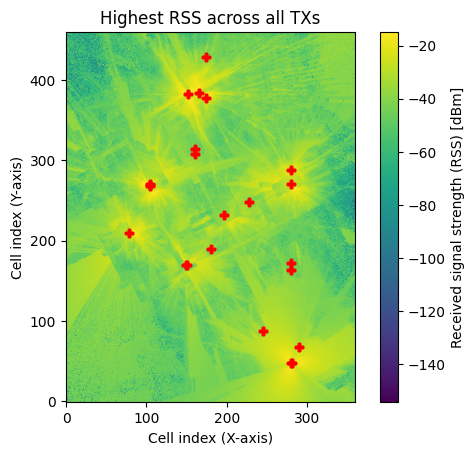

In [ ]:
#Array to store the transmitters once created
transmitters = []

#Creates the array of antennas based on position, 
#note that each antenna position has three 120 degree seperated antennas
for i,_position in enumerate(positions_array):
    #The power of each antenna is divided by 3 by adding  10*log10(1/3) =  -4.771
    transmitters.append(Transmitter(name=f"tx{i}_1", position=_position, display_radius=10, power_dbm=powers_array[i]-4.771))
    first_angle = random.random()*360.0
    transmitters[-1].orientation = (first_angle, 0, 0)
    current_scene.add(transmitters[-1])

    transmitters.append(Transmitter(name=f"tx{i}_2", position=_position, display_radius=10, power_dbm=powers_array[i]-4.771))
    transmitters[-1].orientation = (first_angle+(2 * math.pi/3), 0, 0)
    current_scene.add(transmitters[-1])

    transmitters.append(Transmitter(name=f"tx{i}_3", position=_position, display_radius=10, power_dbm=powers_array[i]-4.771))
    transmitters[-1].orientation = (first_angle+(4 * math.pi/3), 0, 0)
    current_scene.add(transmitters[-1])
    
rm_solver = RadioMapSolver()
rm = rm_solver(current_scene,
               max_depth=30,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(5, 5),      # Resolution of the radio map
               center=[0, 10, 1],      # Center of the radio map
               size=[1800, 2300],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical


#Calculates a radio max for the max power recieved from any ONE reciever at a given cell position
rm.show(metric="rss")
current_scene.preview(radio_map=rm);



#Note: use rm.rss[#transmitter][x][y] to sample the radio map for the recieved signal strength by a given transmitter at a
#given x and y for the radio map (THIS IS NOT THE SAME X AND Y AS IN THE POSITION OF THE ANTENNAS, THE RADIO MAPS AND 
#SIMULATION ENVIORNMENT HAVE DIFFERENT POSITION VALUES, USE THE GRID OF THE RADIO MAP TO FIGURE OUT A POSITION TO SAMPLE)

c:\Users\wonde\Documents\Extra_School_files\NSERC Research\Github\NSERC_RF_harvesting\radio_functions.py:625: RuntimeWarning: overflow encountered in exp
  psig /= 1 + np.exp(-a*input_power + b)


| Type   |   Recieved Power (dbm) |   DC energy (dbm) | time (s)   |
|--------+------------------------+-------------------+------------|
| Mean   |               -39.6838 |              -140 |            |
| Q1     |               -43.1144 |              -140 |            |
| Median |               -38.2006 |              -140 |            |
| Q3     |               -33.2868 |              -140 |            |


| Not enough RF   | Charging   | Saturation   |
|-----------------+------------+--------------|
| 87.147%         | 12.853%    | 0.000%       |


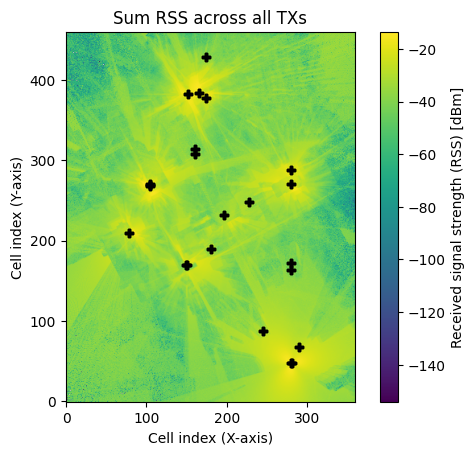

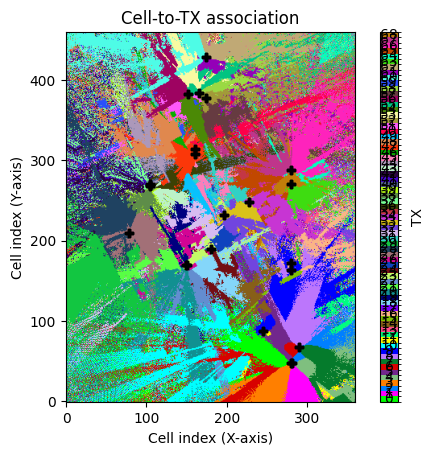

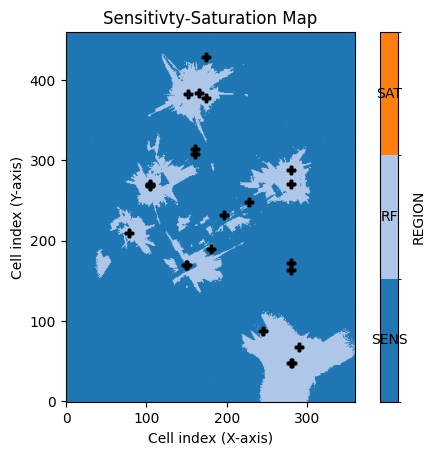

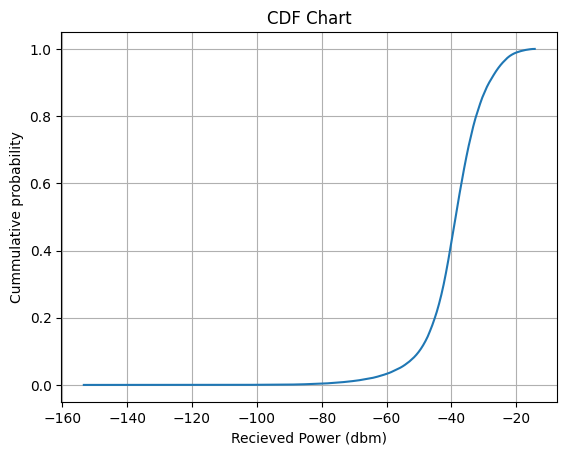

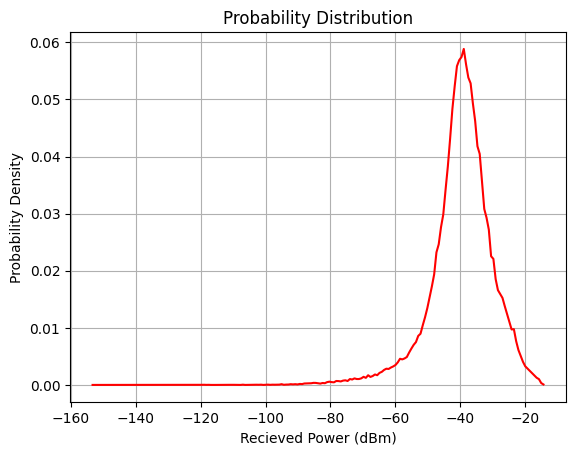

In [ ]:
#Additional functions from the "radio_functions" script, note that the documentation for that class is still quite poor 
#and needs to be updated

#Calculates a CDF chart of the power recieved for the powered summed from each transmitter
cdf_values = radio_functions.sum_cdf(rm, metric="rss");

#Calculates mean, median and other things from the above calculated cdf values
metrics = radio_functions.calculate_metrics_from_cdf(cdf_values)

#prints mean, median, quartiles and radio power harvesting coverage
metrics.print_related_values()

#Displays CDF and PDF (probability distirbution for the power recieved) charts
metrics.display_cdf_and_pdf(cdf_values[2])

#Displays a sum radio map for the power recieved summed from each transmitter
radio_functions.show_sum(rm, metric="rss")

#Shows the transmitter giving the max power at each given cell position (kind of hard to read)
radio_functions.show_association_more_colours(rm)

#Shows the charging map for radio power harvesting coverage 
radio_functions.show_DC_regions(rm, metric="rss")



